In [1]:
#### Etape1 Importation des bibliothèques #######
# Importation des bibliothèques nécessaires
import pandas as pd  # Manipulation des données
import numpy as np  # Calculs mathématiques
import matplotlib.pyplot as plt  # Visualisation des données
import seaborn as sns  # Visualisation avancée des données
from sklearn.model_selection import train_test_split  # Division des données en train/test
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Normalisation et encodage
from sklearn.tree import DecisionTreeClassifier  # Modèle d'arbre de décision
from sklearn.cluster import KMeans  # Modèle de clustering K-Means
from sklearn.metrics import classification_report, accuracy_score  # Évaluation des modèles
from keras.models import Sequential  # Construction du modèle CNN
from keras.layers import Dense, Dropout  # Couches du modèle CNN

In [2]:
data = pd.read_csv('dataset_phishing.csv')  # Remplacer par le nom de votre fichier

# Afficher les colonnes disponibles
print("Colonnes du dataset :")
print(data.columns)


Colonnes du dataset :
Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       

In [3]:
data.shape

(11430, 89)

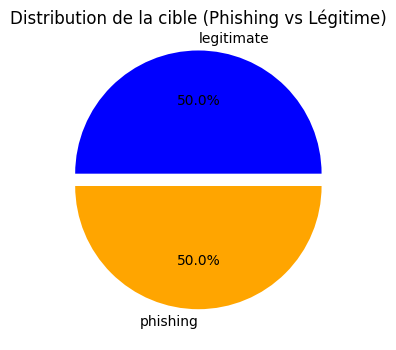

In [4]:
# Visualisation de la distribution de la cible
plt.figure(figsize=(6, 4))
data['status'].value_counts(normalize=True).plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['blue', 'orange'],
    explode=[0.1, 0]
    )
plt.title('Distribution de la cible (Phishing vs Légitime)')
plt.ylabel('')
plt.show()

In [5]:
# Séparer les colonnes numériques et non numériques
numeric_cols = data.select_dtypes(include=['number']).columns  # Colonnes numériques
non_numeric_cols = data.select_dtypes(exclude=['number']).columns  # Colonnes non numériques

# Gestion des valeurs manquantes : Remplir les colonnes numériques avec la moyenne
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Gestion des valeurs manquantes pour les colonnes non numériques : Remplir par une valeur par défaut (ex: "unknown")
data[non_numeric_cols] = data[non_numeric_cols].fillna("unknown")

# Encodage des variables catégoriques en numériques si nécessaire
label_encoder = LabelEncoder()
for col in non_numeric_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Séparation des caractéristiques (X) et de la cible (y)
X = data.drop('status', axis=1)  # Toutes les colonnes sauf la cible
y = data['status']  # Colonne cible

# Normalisation des caractéristiques
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Division en ensembles d'entraînement et de test (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.shape

(9144, 88)

In [7]:
X_train

array([[ 1.34884913,  0.3413211 ,  0.54837858, ..., -0.14330288,
         0.93426411, -1.25578819],
       [-0.69394014,  0.93812118,  0.27000022, ..., -0.14330288,
        -1.07036115, -0.46740717],
       [-0.25264917, -0.40015778, -0.19396372, ..., -0.14330288,
        -1.07036115,  1.50354538],
       ...,
       [-1.45468214, -0.45441233, -0.10117093, ..., -0.14330288,
         0.93426411, -0.46740717],
       [ 0.48960468, -0.63526084, -0.37954929, ..., -0.14330288,
         0.93426411, -0.46740717],
       [-1.32799284, -0.05654562, -0.37954929, ..., -0.14330288,
         0.93426411,  0.71516436]])

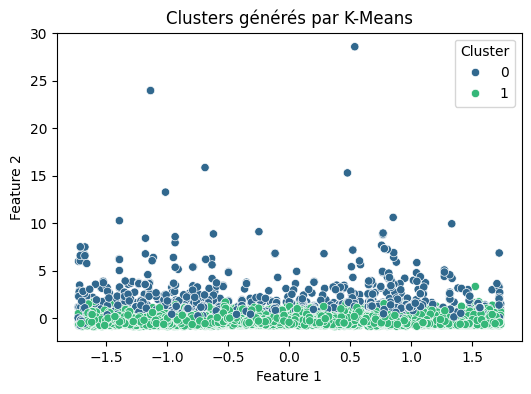

In [8]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Ajout des clusters dans les données pour visualisation
data['Cluster'] = kmeans.labels_

# Visualisation des clusters
plt.figure(figsize=(6, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=data['Cluster'], palette='viridis')
plt.title('Clusters générés par K-Means')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

**1DCNN**

In [62]:
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from tqdm import tqdm
import psutil

# Constants
BATCH_SIZE = 32
NUM_ROUNDS = 30
NUM_CLIENTS = 4  # Minimum must be 2

# Assuming X_train, y_train, X_test, y_test are defined and preprocessed

# Step 1: Define the Model Creation Function
def create_model():
    cnn_model = Sequential()
    cnn_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer
    cnn_model.add(Dropout(0.5))  # Regularization
    cnn_model.add(Dense(32, activation='relu'))
    cnn_model.add(Dense(1, activation='sigmoid'))  # Output layer (binary)
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_model

# Step 2: Reshape Input Data
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten to (samples, features)
X_test = X_test.reshape(X_test.shape[0], -1)      # Flatten to (samples, features)

# Step 3: Initialize the Global Model
global_model = create_model()

global_acc_list_CNN = []
global_loss_list_CNN = []

start_wall_time = time.time()  # Start wall time
start_cpu_time = psutil.cpu_times().user  # Start CPU time

for epoch in range(NUM_ROUNDS):
    print(f'ROUND #{epoch + 1}/{NUM_ROUNDS} ')

    # Client preparation
    client_models = []
    for i in range(NUM_CLIENTS):
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())
        client_models.append(client_model)

    # Training on local data
    for i in tqdm(range(NUM_CLIENTS)):
        print(f'___________________Training CLIENT #{i + 1}')

        # Allocating data to each client
        start = i * (len(X_train) // NUM_CLIENTS)
        end = (i + 1) * (len(X_train) // NUM_CLIENTS)
        X_train_i = X_train[start:end]
        y_train_i = y_train[start:end]

        # Define Checkpoint Callback for each client
        checkpoint = ModelCheckpoint(f"client_model_{i}.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=0)

        # Train the model
        client_models[i].fit(X_train_i, y_train_i, batch_size=BATCH_SIZE, epochs=2, verbose=0, validation_split=0.2, callbacks=[checkpoint])

    # Federated Averaging
    average_weights = []
    for j in tqdm(range(len(global_model.get_weights()))):
        layer_weights = np.array([client_models[i].get_weights()[j] for i in range(NUM_CLIENTS)])
        average_layer_weights = np.mean(layer_weights, axis=0)
        average_weights.append(average_layer_weights)

    # Global Aggregation
    global_model.set_weights(average_weights)

    # Evaluate the global model on training data
    loss, acc = global_model.evaluate(X_train, y_train, verbose=0)
    print(f'Global Train Loss: {loss}, Global Train Accuracy: {acc}')

    # Evaluate on test data
    loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
    global_acc_list_CNN.append(acc)
    global_loss_list_CNN.append(loss)
    print(f'Global Validation Loss: {loss}, Global Validation Accuracy: {acc}\n_________________________________________________________')

end_wall_time = time.time()  # End wall time
end_cpu_time = psutil.cpu_times().user  # End CPU time

# Calculate time durations
wall_time = end_wall_time - start_wall_time
cpu_time = end_cpu_time - start_cpu_time

print(f"Total CPU Time: {cpu_time:.2f} seconds")
print(f"Total Wall Time: {wall_time:.2f} seconds")

# Print global accuracy and loss lists
print("Global Accuracy List (CNN):", global_acc_list_CNN)
print("Global Loss List (CNN):", global_loss_list_CNN)


ROUND #1/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.17s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.12s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.19s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 185.12it/s]

Global Train Loss: 0.19694611430168152, Global Train Accuracy: 0.9253062009811401
Global Validation Loss: 0.19024567306041718, Global Validation Accuracy: 0.9291338324546814
_________________________________________________________
ROUND #2/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.09s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.10s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.04s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 180.77it/s]

Global Train Loss: 0.15181846916675568, Global Train Accuracy: 0.9441163539886475
Global Validation Loss: 0.14523348212242126, Global Validation Accuracy: 0.9470691084861755
_________________________________________________________
ROUND #3/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:00<00:02,  1.04it/s]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.06s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.02s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 208.90it/s]

Global Train Loss: 0.14152954518795013, Global Train Accuracy: 0.9480533599853516
Global Validation Loss: 0.13715724647045135, Global Validation Accuracy: 0.9540682435035706
_________________________________________________________
ROUND #4/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.11s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.07s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.07s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 190.00it/s]

Global Train Loss: 0.13395723700523376, Global Train Accuracy: 0.9512248635292053
Global Validation Loss: 0.13062554597854614, Global Validation Accuracy: 0.9545056819915771
_________________________________________________________
ROUND #5/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.05s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.13s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.09s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 248.61it/s]

Global Train Loss: 0.12707564234733582, Global Train Accuracy: 0.9535214304924011
Global Validation Loss: 0.1250581592321396, Global Validation Accuracy: 0.9575678110122681
_________________________________________________________
ROUND #6/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.06s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.01s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.01s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 116.60it/s]

Global Train Loss: 0.12228496372699738, Global Train Accuracy: 0.9561461210250854
Global Validation Loss: 0.1228814348578453, Global Validation Accuracy: 0.9571303725242615
_________________________________________________________
ROUND #7/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.06s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.10s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.05s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 210.95it/s]

Global Train Loss: 0.11897899955511093, Global Train Accuracy: 0.9575678110122681
Global Validation Loss: 0.12192028760910034, Global Validation Accuracy: 0.9601925015449524
_________________________________________________________
ROUND #8/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:04,  1.55s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.27s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.17s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.36it/s]

Global Train Loss: 0.11477438360452652, Global Train Accuracy: 0.9588801264762878
Global Validation Loss: 0.1174311712384224, Global Validation Accuracy: 0.9588801264762878
_________________________________________________________
ROUND #9/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.14s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.14s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.09s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 158.13it/s]

Global Train Loss: 0.11297182738780975, Global Train Accuracy: 0.9599737524986267
Global Validation Loss: 0.11608432978391647, Global Validation Accuracy: 0.9628171324729919
_________________________________________________________
ROUND #10/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.15s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.13s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.13s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 192.39it/s]

Global Train Loss: 0.10946668684482574, Global Train Accuracy: 0.9610673785209656
Global Validation Loss: 0.11538144946098328, Global Validation Accuracy: 0.9619422554969788
_________________________________________________________
ROUND #11/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.28s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.22s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.14s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 173.96it/s]

Global Train Loss: 0.10710304975509644, Global Train Accuracy: 0.962598443031311
Global Validation Loss: 0.11386509239673615, Global Validation Accuracy: 0.9645669460296631
_________________________________________________________
ROUND #12/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.06s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.27s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.18s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 175.83it/s]

Global Train Loss: 0.10458549857139587, Global Train Accuracy: 0.9633639454841614
Global Validation Loss: 0.11096232384443283, Global Validation Accuracy: 0.9641295075416565
_________________________________________________________
ROUND #13/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.08s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.23s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.21s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 175.52it/s]

Global Train Loss: 0.10442645102739334, Global Train Accuracy: 0.9640201330184937
Global Validation Loss: 0.11391908675432205, Global Validation Accuracy: 0.9636920094490051
_________________________________________________________
ROUND #14/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.09s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.12s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.11s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 178.29it/s]

Global Train Loss: 0.10329656302928925, Global Train Accuracy: 0.9646762609481812
Global Validation Loss: 0.1143912598490715, Global Validation Accuracy: 0.9641295075416565
_________________________________________________________
ROUND #15/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.03s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.11s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.08s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 163.79it/s]

Global Train Loss: 0.10176465660333633, Global Train Accuracy: 0.9659886360168457
Global Validation Loss: 0.11529824137687683, Global Validation Accuracy: 0.9636920094490051
_________________________________________________________
ROUND #16/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.07s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.00s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.23s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 165.13it/s]

Global Train Loss: 0.10099279880523682, Global Train Accuracy: 0.9655511975288391
Global Validation Loss: 0.11209922283887863, Global Validation Accuracy: 0.9641295075416565
_________________________________________________________
ROUND #17/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.09s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.07s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.12s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.87it/s]

Global Train Loss: 0.09875638037919998, Global Train Accuracy: 0.9671915769577026
Global Validation Loss: 0.10944866389036179, Global Validation Accuracy: 0.9645669460296631
_________________________________________________________
ROUND #18/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.16s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.09s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.10s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 177.48it/s]

Global Train Loss: 0.09798294305801392, Global Train Accuracy: 0.9678477644920349
Global Validation Loss: 0.11185077577829361, Global Validation Accuracy: 0.9663166999816895
_________________________________________________________
ROUND #19/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.32s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.16s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.14s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 110.65it/s]

Global Train Loss: 0.09681204706430435, Global Train Accuracy: 0.9681758284568787
Global Validation Loss: 0.10942015051841736, Global Validation Accuracy: 0.9650043845176697
_________________________________________________________
ROUND #20/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.10s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.10s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.33s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 147.10it/s]

Global Train Loss: 0.09524286538362503, Global Train Accuracy: 0.9693788290023804
Global Validation Loss: 0.11042480170726776, Global Validation Accuracy: 0.9663166999816895
_________________________________________________________
ROUND #21/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.07s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.04s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.09s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.06it/s]

Global Train Loss: 0.09507524222135544, Global Train Accuracy: 0.9697068929672241
Global Validation Loss: 0.11072982102632523, Global Validation Accuracy: 0.9654418230056763
_________________________________________________________
ROUND #22/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:00<00:02,  1.05it/s]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.07s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.11s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 159.32it/s]

Global Train Loss: 0.09462597221136093, Global Train Accuracy: 0.9699256420135498
Global Validation Loss: 0.11083178222179413, Global Validation Accuracy: 0.9636920094490051
_________________________________________________________
ROUND #23/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.23s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.13s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.12s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 176.01it/s]

Global Train Loss: 0.09313605725765228, Global Train Accuracy: 0.9705818295478821
Global Validation Loss: 0.11168081313371658, Global Validation Accuracy: 0.9663166999816895
_________________________________________________________
ROUND #24/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.05s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.06s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.16s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.19it/s]

Global Train Loss: 0.09387017786502838, Global Train Accuracy: 0.9711285829544067
Global Validation Loss: 0.11206059902906418, Global Validation Accuracy: 0.9658792614936829
_________________________________________________________
ROUND #25/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.02s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.02s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.09s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 185.41it/s]

Global Train Loss: 0.09169816970825195, Global Train Accuracy: 0.9718941450119019
Global Validation Loss: 0.11211632192134857, Global Validation Accuracy: 0.9663166999816895
_________________________________________________________
ROUND #26/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:00<00:02,  1.01it/s]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:01<00:01,  1.07it/s]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:02<00:00,  1.03it/s]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.51it/s]

Global Train Loss: 0.0919104516506195, Global Train Accuracy: 0.9715660810470581
Global Validation Loss: 0.11041800677776337, Global Validation Accuracy: 0.9680665135383606
_________________________________________________________
ROUND #27/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.09s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.17s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.25s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.26it/s]

Global Train Loss: 0.09162940829992294, Global Train Accuracy: 0.9718941450119019
Global Validation Loss: 0.1124749630689621, Global Validation Accuracy: 0.967629075050354
_________________________________________________________
ROUND #28/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.04s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.10s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.09s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 123.23it/s]

Global Train Loss: 0.09068033844232559, Global Train Accuracy: 0.9724409580230713
Global Validation Loss: 0.11199723929166794, Global Validation Accuracy: 0.967629075050354
_________________________________________________________
ROUND #29/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:05,  1.68s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.31s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.15s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 123.63it/s]

Global Train Loss: 0.08989103138446808, Global Train Accuracy: 0.9734252095222473
Global Validation Loss: 0.11317291855812073, Global Validation Accuracy: 0.9658792614936829
_________________________________________________________
ROUND #30/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.13s/it]

___________________Training CLIENT #2


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.10s/it]

___________________Training CLIENT #3


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.14s/it]

___________________Training CLIENT #4




00%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 191.11it/s]

Global Train Loss: 0.08875175565481186, Global Train Accuracy: 0.9741907119750977
Global Validation Loss: 0.11087793111801147, Global Validation Accuracy: 0.9680665135383606
_________________________________________________________
Total CPU Time: 36.72 seconds
Total Wall Time: 159.93 seconds
Global Accuracy List (CNN): [0.9291338324546814, 0.9470691084861755, 0.9540682435035706, 0.9545056819915771, 0.9575678110122681, 0.9571303725242615, 0.9601925015449524, 0.9588801264762878, 0.9628171324729919, 0.9619422554969788, 0.9645669460296631, 0.9641295075416565, 0.9636920094490051, 0.9641295075416565, 0.9636920094490051, 0.9641295075416565, 0.9645669460296631, 0.9663166999816895, 0.9650043845176697, 0.9663166999816895, 0.9654418230056763, 0.9636920094490051, 0.9663166999816895, 0.9658792614936829, 0.9663166999816895, 0.9680665135383606, 0.967629075050354, 0.967629075050354, 0.9658792614936829, 0.9680665135383606]
Global Loss List (CNN): [0.19024567306041718, 0.14523348212242126, 0.1371572464

In [63]:
train_loss, train_acc = global_model.evaluate(X_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")

286/286 [==============================] - 1s 2ms/step - loss: 0.0888 - accuracy: 0.9742
Global Train Accuracy : 0.9741907119750977
Global Train Loss : 0.08875175565481186


In [64]:
train_loss, train_acc = global_model.evaluate(X_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")

val_loss, val_acc = global_model.evaluate(X_test, y_test)
print(f"Global Validation Accuracy : {val_acc}")
print(f"Global Validation Loss : {val_loss}")

72/72 [==============================] - 0s 3ms/step - loss: 0.1109 - accuracy: 0.9681
Global Validation Accuracy : 0.9680665135383606
Global Validation Loss : 0.11087793111801147


Text(0.5, 1.0, 'Global Acc')

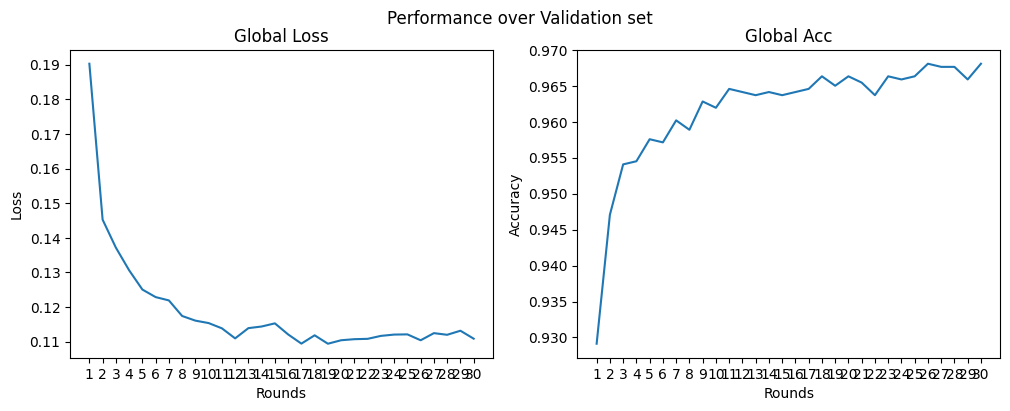

In [65]:
plt.style.use('default')
plt.figure(figsize=(12,4))
plt.suptitle("Performance over Validation set")

plt.subplot(121)
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.plot(range(1, len(global_loss_list_CNN)+1), global_loss_list_CNN)
plt.xticks(range(1, len(global_loss_list_CNN)+1))
plt.title("Global Loss")

plt.subplot(122)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.plot(range(1, len(global_acc_list_CNN)+1), global_acc_list_CNN)
plt.xticks(range(1, len(global_acc_list_CNN)+1))
plt.title("Global Acc")

In [66]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Generate predictions
predictions = global_model.predict(X_test)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32").flatten()  # Convert to 1D array

# Check the shape of y_test
print("y_test shape:", y_test.shape)

# If y_test is one-hot encoded, convert it to binary labels
if len(y_test.shape) == 2 and y_test.shape[1] == 2:  # Assuming two classes
    true_labels = tf.argmax(y_test, axis=1).numpy()  # Convert to 1D array
else:
    true_labels = y_test  # Already 1D array

# Print classification metrics
class_report = classification_report(true_labels, predicted_labels, digits=6, zero_division=0)
print(class_report)

72/72 [==============================] - 0s 1ms/step
y_test shape: (2286,)
              precision    recall  f1-score   support

           0   0.965636  0.971478  0.968548      1157
           1   0.970588  0.964570  0.967570      1129

    accuracy                       0.968066      2286
   macro avg   0.968112  0.968024  0.968059      2286
weighted avg   0.968082  0.968066  0.968065      2286



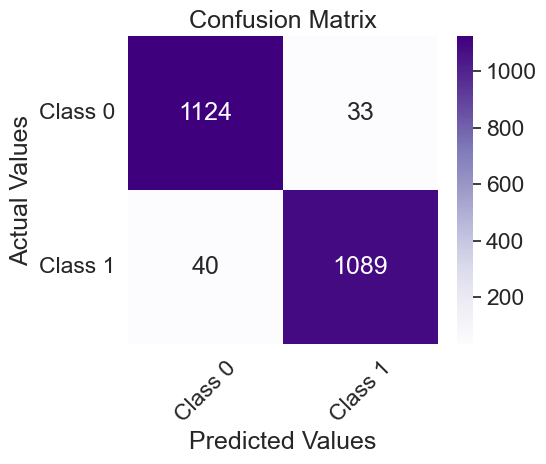

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming true_labels and predicted_labels are already defined

# Define class names for your binary classification
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, 
                 xticklabels=class_names, yticklabels=class_names)

# Labeling the axes
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Show the plot
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#**FedAVGLSTM**

In [68]:
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

# Constants
BATCH_SIZE = 32
NUM_ROUNDS = 30
NUM_CLIENTS = 4  # Minimum must be 2

# Assuming X_train, y_train, X_test, and y_test are defined and preprocessed

# Reshape data for LSTM (samples, time_steps=1, features)
if len(X_train.shape) == 2:
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

if len(X_test.shape) == 2:
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Step 1: Define the Model Creation Function
def create_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 2: Initialize the Global Model
global_model = create_model()

# Lists to store accuracy and loss
global_acc_list_LSTM = []
global_loss_list_LSTM = []

# Start timing
cpu_start = time.process_time()
wall_start = time.time()

# Federated Learning Process
for epoch in range(NUM_ROUNDS):
    print(f'ROUND #{epoch + 1}/{NUM_ROUNDS}')

    # Client preparation
    client_models = []
    for i in range(NUM_CLIENTS):
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())
        client_models.append(client_model)

    # Training on local data
    for i in tqdm(range(NUM_CLIENTS)):
        print(f'____ Training CLIENT #{i + 1} ____')

        # Split data among clients
        start = i * (len(X_train) // NUM_CLIENTS)
        end = (i + 1) * (len(X_train) // NUM_CLIENTS)
        X_train_i = X_train[start:end]
        y_train_i = y_train[start:end]

        # ModelCheckpoint for saving the best model per client
        checkpoint = ModelCheckpoint(f"client_model_{i}.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=0)

        # Train model
        client_models[i].fit(X_train_i, y_train_i, batch_size=BATCH_SIZE, epochs=2, verbose=0, validation_split=0.2, callbacks=[checkpoint])

    # Federated Averaging
    average_weights = []
    for j in tqdm(range(len(global_model.get_weights()))):
        layer_weights = np.array([client_models[i].get_weights()[j] for i in range(NUM_CLIENTS)])
        average_layer_weights = np.mean(layer_weights, axis=0)
        average_weights.append(average_layer_weights)

    # Update Global Model
    global_model.set_weights(average_weights)

    # Evaluate the global model
    loss, acc = global_model.evaluate(X_train, y_train, verbose=0)
    print(f'Global Train Loss: {loss:.4f}, Global Train Accuracy: {acc:.4f}')

    # Evaluate on test set
    loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
    global_acc_list_LSTM.append(acc)
    global_loss_list_LSTM.append(loss)
    print(f'Global Validation Loss: {loss:.4f}, Global Validation Accuracy: {acc:.4f}')
    print('_________________________________________________________')

# Stop timing
cpu_end = time.process_time()
wall_end = time.time()

# Print CPU & Wall Time
print(f"Total CPU Time: {cpu_end - cpu_start:.2f} seconds")
print(f"Total Wall Time: {wall_end - wall_start:.2f} seconds")

# Print Global Accuracy and Loss Lists
print("\nGlobal Accuracy List (LSTM):", global_acc_list_LSTM)
print("Global Loss List (LSTM):", global_loss_list_LSTM)


ROUND #1/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:05<00:17,  5.92s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:10<00:10,  5.00s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:14<00:04,  4.62s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 100.57it/s]

Global Train Loss: 0.1955, Global Train Accuracy: 0.9307
Global Validation Loss: 0.1887, Global Validation Accuracy: 0.9339
_________________________________________________________
ROUND #2/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.03s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.08s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:13<00:04,  4.48s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 100.25it/s]

Global Train Loss: 0.1443, Global Train Accuracy: 0.9464
Global Validation Loss: 0.1323, Global Validation Accuracy: 0.9497
_________________________________________________________
ROUND #3/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.19s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:09<00:09,  4.60s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:13<00:04,  4.42s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 121.98it/s]

Global Train Loss: 0.1329, Global Train Accuracy: 0.9505
Global Validation Loss: 0.1207, Global Validation Accuracy: 0.9549
_________________________________________________________
ROUND #4/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.87s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.95s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.07s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 127.99it/s]

Global Train Loss: 0.1251, Global Train Accuracy: 0.9537
Global Validation Loss: 0.1134, Global Validation Accuracy: 0.9584
_________________________________________________________
ROUND #5/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.18s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:09,  4.55s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.22s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 132.33it/s]

Global Train Loss: 0.1198, Global Train Accuracy: 0.9560
Global Validation Loss: 0.1102, Global Validation Accuracy: 0.9589
_________________________________________________________
ROUND #6/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:14,  4.67s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.29s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.13s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 132.57it/s]

Global Train Loss: 0.1145, Global Train Accuracy: 0.9580
Global Validation Loss: 0.1073, Global Validation Accuracy: 0.9641
_________________________________________________________
ROUND #7/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.80s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.82s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.87s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 124.17it/s]

Global Train Loss: 0.1095, Global Train Accuracy: 0.9607
Global Validation Loss: 0.1045, Global Validation Accuracy: 0.9619
_________________________________________________________
ROUND #8/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.87s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.88s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.11s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 130.76it/s]

Global Train Loss: 0.1055, Global Train Accuracy: 0.9633
Global Validation Loss: 0.1017, Global Validation Accuracy: 0.9633
_________________________________________________________
ROUND #9/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.98s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.45s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.30s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 136.78it/s]

Global Train Loss: 0.1023, Global Train Accuracy: 0.9640
Global Validation Loss: 0.1020, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #10/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.76s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.92s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:04,  4.02s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 120.31it/s]

Global Train Loss: 0.0988, Global Train Accuracy: 0.9651
Global Validation Loss: 0.1004, Global Validation Accuracy: 0.9654
_________________________________________________________
ROUND #11/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:10,  3.66s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.68s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.96s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 123.07it/s]

Global Train Loss: 0.0963, Global Train Accuracy: 0.9665
Global Validation Loss: 0.1009, Global Validation Accuracy: 0.9654
_________________________________________________________
ROUND #12/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.98s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.34s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.06s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 127.89it/s]

Global Train Loss: 0.0939, Global Train Accuracy: 0.9683
Global Validation Loss: 0.1014, Global Validation Accuracy: 0.9659
_________________________________________________________
ROUND #13/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.87s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.78s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.90s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 117.10it/s]

Global Train Loss: 0.0914, Global Train Accuracy: 0.9695
Global Validation Loss: 0.1003, Global Validation Accuracy: 0.9654
_________________________________________________________
ROUND #14/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.97s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.17s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.05s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 125.48it/s]

Global Train Loss: 0.0887, Global Train Accuracy: 0.9706
Global Validation Loss: 0.1001, Global Validation Accuracy: 0.9685
_________________________________________________________
ROUND #15/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:13,  4.48s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.05s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:03,  3.93s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 147.01it/s]

Global Train Loss: 0.0877, Global Train Accuracy: 0.9704
Global Validation Loss: 0.1033, Global Validation Accuracy: 0.9668
_________________________________________________________
ROUND #16/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.70s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.82s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.77s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 143.93it/s]

Global Train Loss: 0.0856, Global Train Accuracy: 0.9718
Global Validation Loss: 0.1024, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #17/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.01s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.81s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.09s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 138.75it/s]

Global Train Loss: 0.0833, Global Train Accuracy: 0.9724
Global Validation Loss: 0.0998, Global Validation Accuracy: 0.9676
_________________________________________________________
ROUND #18/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.84s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.22s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.06s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 138.48it/s]

Global Train Loss: 0.0821, Global Train Accuracy: 0.9722
Global Validation Loss: 0.1008, Global Validation Accuracy: 0.9672
_________________________________________________________
ROUND #19/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.90s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.82s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.78s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 137.38it/s]

Global Train Loss: 0.0807, Global Train Accuracy: 0.9727
Global Validation Loss: 0.1030, Global Validation Accuracy: 0.9685
_________________________________________________________
ROUND #20/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.75s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.86s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.19s/it]

____ Training CLIENT #4 ____




00%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 83.95it/s]

Global Train Loss: 0.0800, Global Train Accuracy: 0.9735
Global Validation Loss: 0.1027, Global Validation Accuracy: 0.9685
_________________________________________________________
ROUND #21/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.95s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.48s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.18s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 104.21it/s]

Global Train Loss: 0.0779, Global Train Accuracy: 0.9747
Global Validation Loss: 0.1077, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #22/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.78s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.99s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.33s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 117.78it/s]

Global Train Loss: 0.0777, Global Train Accuracy: 0.9745
Global Validation Loss: 0.1084, Global Validation Accuracy: 0.9672
_________________________________________________________
ROUND #23/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.83s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.38s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.28s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 112.40it/s]

Global Train Loss: 0.0770, Global Train Accuracy: 0.9739
Global Validation Loss: 0.1096, Global Validation Accuracy: 0.9676
_________________________________________________________
ROUND #24/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:14,  4.91s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.36s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.13s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 138.54it/s]

Global Train Loss: 0.0758, Global Train Accuracy: 0.9751
Global Validation Loss: 0.1093, Global Validation Accuracy: 0.9681
_________________________________________________________
ROUND #25/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.03s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.10s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.14s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 128.29it/s]

Global Train Loss: 0.0750, Global Train Accuracy: 0.9756
Global Validation Loss: 0.1056, Global Validation Accuracy: 0.9685
_________________________________________________________
ROUND #26/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.02s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.07s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.22s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 123.90it/s]

Global Train Loss: 0.0742, Global Train Accuracy: 0.9754
Global Validation Loss: 0.1079, Global Validation Accuracy: 0.9672
_________________________________________________________
ROUND #27/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.92s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.46s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.35s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 119.39it/s]

Global Train Loss: 0.0737, Global Train Accuracy: 0.9767
Global Validation Loss: 0.1115, Global Validation Accuracy: 0.9676
_________________________________________________________
ROUND #28/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:05<00:16,  5.45s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:09<00:09,  4.64s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:13<00:04,  4.29s/it]

____ Training CLIENT #4 ____




00%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 95.06it/s]

Global Train Loss: 0.0730, Global Train Accuracy: 0.9769
Global Validation Loss: 0.1118, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #29/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.86s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.98s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.20s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 113.54it/s]

Global Train Loss: 0.0722, Global Train Accuracy: 0.9764
Global Validation Loss: 0.1128, Global Validation Accuracy: 0.9681
_________________________________________________________
ROUND #30/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.81s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.33s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.31s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 120.39it/s]

Global Train Loss: 0.0710, Global Train Accuracy: 0.9775
Global Validation Loss: 0.1088, Global Validation Accuracy: 0.9668
_________________________________________________________
Total CPU Time: 175.11 seconds
Total Wall Time: 576.38 seconds

Global Accuracy List (LSTM): [0.9339457750320435, 0.9496937990188599, 0.9549431204795837, 0.9584426879882812, 0.9588801264762878, 0.9641295075416565, 0.9619422554969788, 0.9632545709609985, 0.9663166999816895, 0.9654418230056763, 0.9654418230056763, 0.9658792614936829, 0.9654418230056763, 0.9685039520263672, 0.966754138469696, 0.9663166999816895, 0.967629075050354, 0.9671915769577026, 0.9685039520263672, 0.9685039520263672, 0.9663166999816895, 0.9671915769577026, 0.967629075050354, 0.9680665135383606, 0.9685039520263672, 0.9671915769577026, 0.967629075050354, 0.9663166999816895, 0.9680665135383606, 0.966754138469696]
Global Loss List (LSTM): [0.1887308657169342, 0.13233786821365356, 0.1207415834069252, 0.11339745670557022, 0.11020287126302719, 

In [71]:
train_loss, train_acc = global_model.evaluate(X_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")

val_loss, val_acc = global_model.evaluate(X_test, y_test)
print(f"Global Validation Accuracy : {val_acc}")
print(f"Global Validation Loss : {val_loss}")

286/286 [==============================] - 1s 4ms/step - loss: 0.0710 - accuracy: 0.9775
Global Train Accuracy : 0.9774715900421143
Global Train Loss : 0.07102390378713608
72/72 [==============================] - 0s 3ms/step - loss: 0.1088 - accuracy: 0.9668
Global Validation Accuracy : 0.966754138469696
Global Validation Loss : 0.1087632030248642


In [69]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Generate predictions
predictions = global_model.predict(X_test)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32").flatten()  # Convert to 1D array

# Check the shape of y_test
print("y_test shape:", y_test.shape)

# If y_test is one-hot encoded, convert it to binary labels
if len(y_test.shape) == 2 and y_test.shape[1] == 2:  # Assuming two classes
    true_labels = tf.argmax(y_test, axis=1).numpy()  # Convert to 1D array
else:
    true_labels = y_test  # Already 1D array

# Print classification metrics
class_report = classification_report(true_labels, predicted_labels, digits=6, zero_division=0)
print(class_report)

72/72 [==============================] - 1s 2ms/step
y_test shape: (2286,)
              precision    recall  f1-score   support

           0   0.964746  0.969749  0.967241      1157
           1   0.968833  0.963685  0.966252      1129

    accuracy                       0.966754      2286
   macro avg   0.966790  0.966717  0.966747      2286
weighted avg   0.966765  0.966754  0.966753      2286



Text(0.5, 1.0, 'Global Acc')

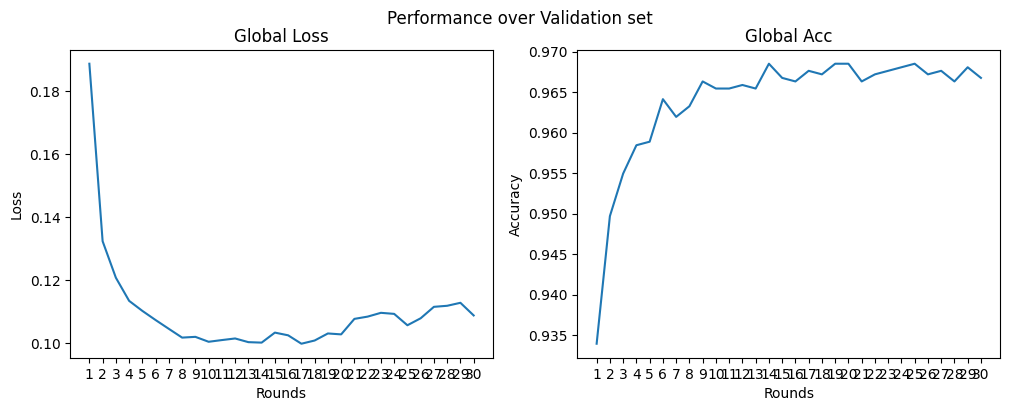

In [72]:
plt.style.use('default')
plt.figure(figsize=(12,4))
plt.suptitle("Performance over Validation set")

plt.subplot(121)
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.plot(range(1, len(global_loss_list_LSTM)+1), global_loss_list_LSTM)
plt.xticks(range(1, len(global_loss_list_LSTM)+1))
plt.title("Global Loss")

plt.subplot(122)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.plot(range(1, len(global_acc_list_LSTM)+1), global_acc_list_LSTM)
plt.xticks(range(1, len(global_acc_list_LSTM)+1))
plt.title("Global Acc")

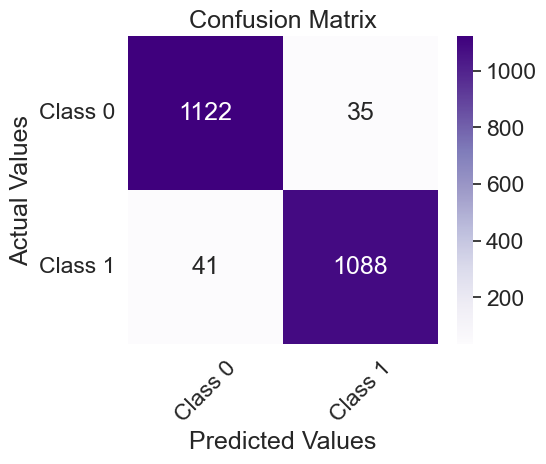

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming true_labels and predicted_labels are already defined

# Define class names for your binary classification
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, 
                 xticklabels=class_names, yticklabels=class_names)

# Labeling the axes
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Show the plot
plt.title('Confusion Matrix')
plt.show()

**BiLSTM**

In [74]:
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

# Constants
BATCH_SIZE = 32
NUM_ROUNDS = 30
NUM_CLIENTS = 4  # Minimum must be 2

# Check the shape of X_train
print("X_train shape before reshaping:", X_train.shape)
if len(X_train.shape) == 2:  # (samples, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps=1, features)

# Check the shape of X_test
print("X_test shape before reshaping:", X_test.shape)
if len(X_test.shape) == 2:  # (samples, features)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # (samples, time_steps=1, features)

# Step 1: Define the Model Creation Function
def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 2: Initialize Global Model
global_model = create_model()

global_acc_list_BiLSTM = []
global_loss_list_BiLSTM = []

# Start timing
cpu_start = time.process_time()
wall_start = time.time()

# Federated Learning Process
for epoch in range(NUM_ROUNDS):
    print(f'ROUND #{epoch + 1}/{NUM_ROUNDS}')

    # Client preparation
    client_models = []
    for i in range(NUM_CLIENTS):
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())
        client_models.append(client_model)

    # Training on local data
    for i in tqdm(range(NUM_CLIENTS)):
        print(f'____ Training CLIENT #{i + 1} ____')

        # Split data among clients
        start = i * (len(X_train) // NUM_CLIENTS)
        end = (i + 1) * (len(X_train) // NUM_CLIENTS)
        X_train_i = X_train[start:end]
        y_train_i = y_train[start:end]

        checkpoint = ModelCheckpoint(f"client_model_{i}.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=0)
        client_models[i].fit(X_train_i, y_train_i, batch_size=BATCH_SIZE, epochs=2, verbose=0, validation_split=0.2, callbacks=[checkpoint])

    # Federated Averaging
    average_weights = []
    for j in tqdm(range(len(global_model.get_weights()))):
        layer_weights = np.array([client_models[i].get_weights()[j] for i in range(NUM_CLIENTS)])
        average_layer_weights = np.mean(layer_weights, axis=0)
        average_weights.append(average_layer_weights)

    # Update Global Model
    global_model.set_weights(average_weights)

    # Evaluate the global model
    loss, acc = global_model.evaluate(X_train, y_train, verbose=0)
    print(f'Global Train Loss: {loss:.4f}, Global Train Accuracy: {acc:.4f}')

    # Evaluate on test set
    loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
    global_acc_list_BiLSTM.append(acc)
    global_loss_list_BiLSTM.append(loss)
    print(f'Global Validation Loss: {loss:.4f}, Global Validation Accuracy: {acc:.4f}')
    print('_________________________________________________________')

# Stop timing
cpu_end = time.process_time()
wall_end = time.time()

# Print CPU & Wall Time
print(f"Total CPU Time: {cpu_end - cpu_start:.2f} seconds")
print(f"Total Wall Time: {wall_end - wall_start:.2f} seconds")

# Print Global Accuracy and Loss Lists
print("\nGlobal Accuracy List (BiLSTM):", global_acc_list_BiLSTM)
print("Global Loss List (BiLSTM):", global_loss_list_BiLSTM)


X_train shape before reshaping: (9144, 1, 88)
X_test shape before reshaping: (2286, 1, 88)
ROUND #1/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:22,  7.46s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.79s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.52s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 61.98it/s]

Global Train Loss: 0.1620, Global Train Accuracy: 0.9403
Global Validation Loss: 0.1515, Global Validation Accuracy: 0.9466
_________________________________________________________
ROUND #2/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:08<00:24,  8.32s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:16<00:16,  8.09s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:23<00:07,  7.60s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 68.42it/s]

Global Train Loss: 0.1362, Global Train Accuracy: 0.9494
Global Validation Loss: 0.1222, Global Validation Accuracy: 0.9541
_________________________________________________________
ROUND #3/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:22,  7.36s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:16<00:17,  8.59s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:24<00:08,  8.04s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 62.45it/s]

Global Train Loss: 0.1265, Global Train Accuracy: 0.9525
Global Validation Loss: 0.1135, Global Validation Accuracy: 0.9593
_________________________________________________________
ROUND #4/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:21,  7.15s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.89s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.46s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 61.10it/s]

Global Train Loss: 0.1190, Global Train Accuracy: 0.9555
Global Validation Loss: 0.1079, Global Validation Accuracy: 0.9633
_________________________________________________________
ROUND #5/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:22,  7.45s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:16,  8.03s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.60s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 69.17it/s]

Global Train Loss: 0.1124, Global Train Accuracy: 0.9587
Global Validation Loss: 0.1065, Global Validation Accuracy: 0.9633
_________________________________________________________
ROUND #6/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:23,  7.75s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:16<00:17,  8.55s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:24<00:08,  8.03s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 68.24it/s]

Global Train Loss: 0.1071, Global Train Accuracy: 0.9604
Global Validation Loss: 0.1030, Global Validation Accuracy: 0.9624
_________________________________________________________
ROUND #7/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:22,  7.63s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:16<00:16,  8.25s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:24<00:08,  8.02s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 67.37it/s]

Global Train Loss: 0.1027, Global Train Accuracy: 0.9630
Global Validation Loss: 0.1017, Global Validation Accuracy: 0.9650
_________________________________________________________
ROUND #8/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:23,  7.82s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.52s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.33s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 62.65it/s]

Global Train Loss: 0.0978, Global Train Accuracy: 0.9650
Global Validation Loss: 0.1000, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #9/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:21,  7.30s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.32s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.29s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 67.69it/s]

Global Train Loss: 0.0942, Global Train Accuracy: 0.9670
Global Validation Loss: 0.1011, Global Validation Accuracy: 0.9659
_________________________________________________________
ROUND #10/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:21,  7.10s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.80s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.37s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 69.04it/s]

Global Train Loss: 0.0914, Global Train Accuracy: 0.9682
Global Validation Loss: 0.1014, Global Validation Accuracy: 0.9659
_________________________________________________________
ROUND #11/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.98s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:15,  7.55s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.20s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 70.39it/s]

Global Train Loss: 0.0884, Global Train Accuracy: 0.9704
Global Validation Loss: 0.0993, Global Validation Accuracy: 0.9668
_________________________________________________________
ROUND #12/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.89s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:15,  7.50s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.19s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 72.91it/s]

Global Train Loss: 0.0858, Global Train Accuracy: 0.9713
Global Validation Loss: 0.0981, Global Validation Accuracy: 0.9659
_________________________________________________________
ROUND #13/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:23,  7.92s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.33s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.30s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 71.65it/s]

Global Train Loss: 0.0839, Global Train Accuracy: 0.9728
Global Validation Loss: 0.1014, Global Validation Accuracy: 0.9676
_________________________________________________________
ROUND #14/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:08<00:24,  8.04s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.65s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.55s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 67.11it/s]

Global Train Loss: 0.0818, Global Train Accuracy: 0.9735
Global Validation Loss: 0.1016, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #15/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.93s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.32s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.10s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 67.65it/s]

Global Train Loss: 0.0797, Global Train Accuracy: 0.9736
Global Validation Loss: 0.1030, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #16/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:23,  7.90s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:14,  7.47s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.38s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 61.52it/s]

Global Train Loss: 0.0790, Global Train Accuracy: 0.9752
Global Validation Loss: 0.1053, Global Validation Accuracy: 0.9654
_________________________________________________________
ROUND #17/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:08<00:24,  8.29s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.86s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:23<00:07,  7.82s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 68.31it/s]

Global Train Loss: 0.0776, Global Train Accuracy: 0.9754
Global Validation Loss: 0.1034, Global Validation Accuracy: 0.9672
_________________________________________________________
ROUND #18/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:22,  7.49s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.56s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.42s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 60.90it/s]

Global Train Loss: 0.0778, Global Train Accuracy: 0.9767
Global Validation Loss: 0.1100, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #19/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:08<00:26,  8.98s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:16<00:16,  8.40s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:24<00:08,  8.01s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 67.64it/s]

Global Train Loss: 0.0768, Global Train Accuracy: 0.9757
Global Validation Loss: 0.1089, Global Validation Accuracy: 0.9654
_________________________________________________________
ROUND #20/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:08<00:26,  8.77s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:16<00:15,  7.90s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:23<00:07,  7.57s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 66.33it/s]

Global Train Loss: 0.0754, Global Train Accuracy: 0.9768
Global Validation Loss: 0.1170, Global Validation Accuracy: 0.9646
_________________________________________________________
ROUND #21/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:21,  7.04s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:15,  7.52s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.50s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 59.89it/s]

Global Train Loss: 0.0729, Global Train Accuracy: 0.9771
Global Validation Loss: 0.1142, Global Validation Accuracy: 0.9668
_________________________________________________________
ROUND #22/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:08<00:25,  8.63s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:16<00:16,  8.08s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:24<00:07,  7.91s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 62.85it/s]

Global Train Loss: 0.0729, Global Train Accuracy: 0.9771
Global Validation Loss: 0.1180, Global Validation Accuracy: 0.9654
_________________________________________________________
ROUND #23/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:08<00:25,  8.49s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.70s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:23<00:07,  7.74s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 74.38it/s]

Global Train Loss: 0.0731, Global Train Accuracy: 0.9774
Global Validation Loss: 0.1163, Global Validation Accuracy: 0.9672
_________________________________________________________
ROUND #24/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:21,  7.03s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.28s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.01s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 71.75it/s]

Global Train Loss: 0.0719, Global Train Accuracy: 0.9783
Global Validation Loss: 0.1198, Global Validation Accuracy: 0.9689
_________________________________________________________
ROUND #25/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:08<00:25,  8.37s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:14,  7.42s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.54s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 66.72it/s]

Global Train Loss: 0.0723, Global Train Accuracy: 0.9795
Global Validation Loss: 0.1249, Global Validation Accuracy: 0.9672
_________________________________________________________
ROUND #26/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:23,  7.96s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:14,  7.44s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.40s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 70.62it/s]

Global Train Loss: 0.0709, Global Train Accuracy: 0.9797
Global Validation Loss: 0.1246, Global Validation Accuracy: 0.9685
_________________________________________________________
ROUND #27/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:21,  7.17s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:15,  7.54s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.26s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 63.65it/s]

Global Train Loss: 0.0705, Global Train Accuracy: 0.9804
Global Validation Loss: 0.1247, Global Validation Accuracy: 0.9672
_________________________________________________________
ROUND #28/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:08<00:24,  8.23s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.69s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:23<00:07,  7.69s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 73.56it/s]

Global Train Loss: 0.0694, Global Train Accuracy: 0.9794
Global Validation Loss: 0.1255, Global Validation Accuracy: 0.9676
_________________________________________________________
ROUND #29/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:08<00:25,  8.57s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.78s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:23<00:07,  7.64s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 63.28it/s]

Global Train Loss: 0.0680, Global Train Accuracy: 0.9808
Global Validation Loss: 0.1316, Global Validation Accuracy: 0.9676
_________________________________________________________
ROUND #30/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.91s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.45s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.43s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 71.67it/s]

Global Train Loss: 0.0691, Global Train Accuracy: 0.9809
Global Validation Loss: 0.1355, Global Validation Accuracy: 0.9681
_________________________________________________________
Total CPU Time: 355.34 seconds
Total Wall Time: 1054.54 seconds

Global Accuracy List (BiLSTM): [0.946631669998169, 0.9540682435035706, 0.9593175649642944, 0.9632545709609985, 0.9632545709609985, 0.9623796939849854, 0.9650043845176697, 0.9663166999816895, 0.9658792614936829, 0.9658792614936829, 0.966754138469696, 0.9658792614936829, 0.967629075050354, 0.9663166999816895, 0.9663166999816895, 0.9654418230056763, 0.9671915769577026, 0.9663166999816895, 0.9654418230056763, 0.9645669460296631, 0.966754138469696, 0.9654418230056763, 0.9671915769577026, 0.9689413905143738, 0.9671915769577026, 0.9685039520263672, 0.9671915769577026, 0.967629075050354, 0.967629075050354, 0.9680665135383606]
Global Loss List (BiLSTM): [0.15147291123867035, 0.12218135595321655, 0.11347462236881256, 0.10791344940662384, 0.1065026149153

In [75]:
train_loss, train_acc = global_model.evaluate(X_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")


val_loss, val_acc = global_model.evaluate(X_test, y_test)
print(f"Global Validation Accuracy : {val_acc}")
print(f"Global Validation Loss : {val_loss}")
     

286/286 [==============================] - 1s 3ms/step - loss: 0.0691 - accuracy: 0.9809
Global Train Accuracy : 0.9808617830276489
Global Train Loss : 0.06913046538829803
72/72 [==============================] - 0s 3ms/step - loss: 0.1355 - accuracy: 0.9681
Global Validation Accuracy : 0.9680665135383606
Global Validation Loss : 0.13554301857948303


In [76]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Generate predictions
predictions = global_model.predict(X_test)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32").flatten()  # Convert to 1D array

# Check the shape of y_test
print("y_test shape:", y_test.shape)

# If y_test is one-hot encoded, convert it to binary labels
if len(y_test.shape) == 2 and y_test.shape[1] == 2:  # Assuming two classes
    true_labels = tf.argmax(y_test, axis=1).numpy()  # Convert to 1D array
else:
    true_labels = y_test  # Already 1D array

# Print classification metrics
class_report = classification_report(true_labels, predicted_labels, digits=6, zero_division=0)
print(class_report)

72/72 [==============================] - 1s 3ms/step
y_test shape: (2286,)
              precision    recall  f1-score   support

           0   0.965636  0.971478  0.968548      1157
           1   0.970588  0.964570  0.967570      1129

    accuracy                       0.968066      2286
   macro avg   0.968112  0.968024  0.968059      2286
weighted avg   0.968082  0.968066  0.968065      2286



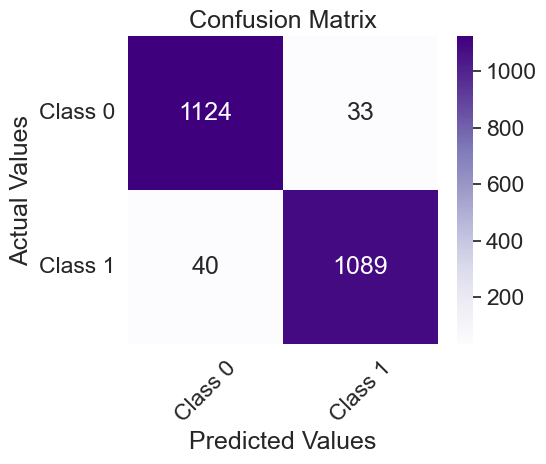

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming true_labels and predicted_labels are already defined

# Define class names for your binary classification
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, 
                 xticklabels=class_names, yticklabels=class_names)

# Labeling the axes
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Show the plot
plt.title('Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'Global Acc')

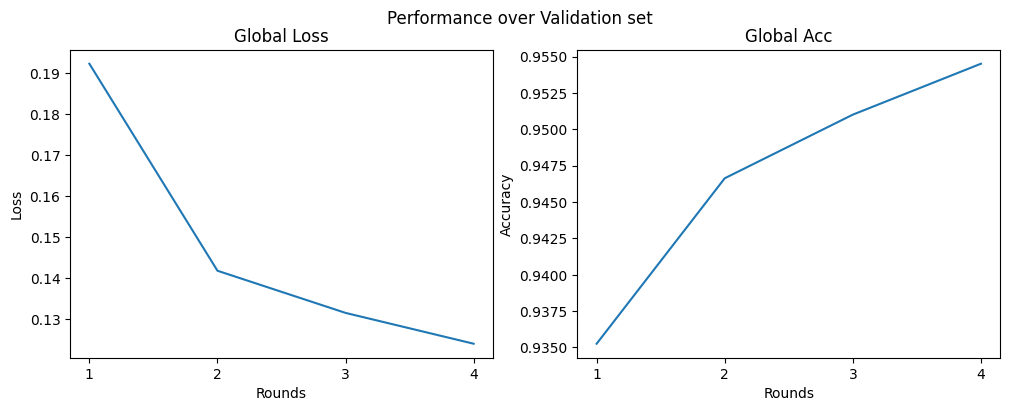

In [29]:
plt.style.use('default')
plt.figure(figsize=(12,4))
plt.suptitle("Performance over Validation set")

plt.subplot(121)
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.plot(range(1, len(global_loss_list_BiLSTM)+1), global_loss_list_BiLSTM)
plt.xticks(range(1, len(global_loss_list_BiLSTM)+1))
plt.title("Global Loss")

plt.subplot(122)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.plot(range(1, len(global_acc_list_BiLSTM)+1), global_acc_list_BiLSTM)
plt.xticks(range(1, len(global_acc_list_BiLSTM)+1))
plt.title("Global Acc")

**BiGRU**

In [78]:
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

# Constants
BATCH_SIZE = 32
NUM_ROUNDS = 30
NUM_CLIENTS = 4  # Minimum must be 2

# Check the shape of X_train
print("X_train shape before reshaping:", X_train.shape)
if len(X_train.shape) == 2:  # (samples, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps=1, features)

# Check the shape of X_test
print("X_test shape before reshaping:", X_test.shape)
if len(X_test.shape) == 2:  # (samples, features)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # (samples, time_steps=1, features)

# Step 1: Define the Model Creation Function
def create_model():
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(Bidirectional(GRU(64)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 2: Initialize Global Model
global_model = create_model()

global_acc_list_BiGRU = []
global_loss_list_BiGRU = []

# Start timing
cpu_start = time.process_time()
wall_start = time.time()

# Federated Learning Process
for epoch in range(NUM_ROUNDS):
    print(f'ROUND #{epoch + 1}/{NUM_ROUNDS}')

    # Client preparation
    client_models = []
    for i in range(NUM_CLIENTS):
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())
        client_models.append(client_model)

    # Training on local data
    for i in tqdm(range(NUM_CLIENTS)):
        print(f'____ Training CLIENT #{i + 1} ____')

        # Split data among clients
        start = i * (len(X_train) // NUM_CLIENTS)
        end = (i + 1) * (len(X_train) // NUM_CLIENTS)
        X_train_i = X_train[start:end]
        y_train_i = y_train[start:end]

        checkpoint = ModelCheckpoint(f"client_model_{i}.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=0)
        client_models[i].fit(X_train_i, y_train_i, batch_size=BATCH_SIZE, epochs=2, verbose=0, validation_split=0.2, callbacks=[checkpoint])

    # Federated Averaging
    average_weights = []
    for j in tqdm(range(len(global_model.get_weights()))):
        layer_weights = np.array([client_models[i].get_weights()[j] for i in range(NUM_CLIENTS)])
        average_layer_weights = np.mean(layer_weights, axis=0)
        average_weights.append(average_layer_weights)

    # Update Global Model
    global_model.set_weights(average_weights)

    # Evaluate the global model
    loss, acc = global_model.evaluate(X_train, y_train, verbose=0)
    print(f'Global Train Loss: {loss:.4f}, Global Train Accuracy: {acc:.4f}')

    # Evaluate on test set
    loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
    global_acc_list_BiGRU.append(acc)
    global_loss_list_BiGRU.append(loss)
    print(f'Global Validation Loss: {loss:.4f}, Global Validation Accuracy: {acc:.4f}')
    print('_________________________________________________________')

# Stop timing
cpu_end = time.process_time()
wall_end = time.time()

# Print CPU & Wall Time
print(f"Total CPU Time: {cpu_end - cpu_start:.2f} seconds")
print(f"Total Wall Time: {wall_end - wall_start:.2f} seconds")

# Print Global Accuracy and Loss Lists
print("\nGlobal Accuracy List (BiGRU):", global_acc_list_BiGRU)
print("Global Loss List (BiGRU):", global_loss_list_BiGRU)


X_train shape before reshaping: (9144, 1, 88)
X_test shape before reshaping: (2286, 1, 88)
ROUND #1/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:08<00:26,  8.78s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:16<00:15,  7.92s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:23<00:07,  7.74s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 61.76it/s]

Global Train Loss: 0.1533, Global Train Accuracy: 0.9431
Global Validation Loss: 0.1356, Global Validation Accuracy: 0.9493
_________________________________________________________
ROUND #2/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:21,  7.06s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.66s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.56s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 58.67it/s]

Global Train Loss: 0.1388, Global Train Accuracy: 0.9482
Global Validation Loss: 0.1198, Global Validation Accuracy: 0.9571
_________________________________________________________
ROUND #3/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:19,  6.47s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.31s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.01s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 60.89it/s]

Global Train Loss: 0.1309, Global Train Accuracy: 0.9520
Global Validation Loss: 0.1142, Global Validation Accuracy: 0.9598
_________________________________________________________
ROUND #4/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.74s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.68s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.36s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 72.69it/s]

Global Train Loss: 0.1254, Global Train Accuracy: 0.9538
Global Validation Loss: 0.1124, Global Validation Accuracy: 0.9606
_________________________________________________________
ROUND #5/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:21,  7.19s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.78s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.43s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 70.07it/s]

Global Train Loss: 0.1192, Global Train Accuracy: 0.9566
Global Validation Loss: 0.1077, Global Validation Accuracy: 0.9637
_________________________________________________________
ROUND #6/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.95s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.40s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.30s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 74.72it/s]

Global Train Loss: 0.1144, Global Train Accuracy: 0.9588
Global Validation Loss: 0.1047, Global Validation Accuracy: 0.9646
_________________________________________________________
ROUND #7/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:21,  7.13s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.71s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.48s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 74.71it/s]

Global Train Loss: 0.1105, Global Train Accuracy: 0.9611
Global Validation Loss: 0.1054, Global Validation Accuracy: 0.9611
_________________________________________________________
ROUND #8/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.99s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.89s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.64s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 72.57it/s]

Global Train Loss: 0.1063, Global Train Accuracy: 0.9613
Global Validation Loss: 0.0990, Global Validation Accuracy: 0.9641
_________________________________________________________
ROUND #9/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.82s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:15,  7.53s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.32s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 68.16it/s]

Global Train Loss: 0.1033, Global Train Accuracy: 0.9634
Global Validation Loss: 0.1003, Global Validation Accuracy: 0.9624
_________________________________________________________
ROUND #10/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:21,  7.19s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.81s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.39s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 71.89it/s]

Global Train Loss: 0.1000, Global Train Accuracy: 0.9651
Global Validation Loss: 0.0998, Global Validation Accuracy: 0.9654
_________________________________________________________
ROUND #11/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.89s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:15,  7.54s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.04s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 75.53it/s]

Global Train Loss: 0.0977, Global Train Accuracy: 0.9651
Global Validation Loss: 0.0997, Global Validation Accuracy: 0.9650
_________________________________________________________
ROUND #12/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:19,  6.64s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.43s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.16s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 71.65it/s]

Global Train Loss: 0.0950, Global Train Accuracy: 0.9669
Global Validation Loss: 0.0961, Global Validation Accuracy: 0.9646
_________________________________________________________
ROUND #13/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:22,  7.51s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.08s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.11s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 71.87it/s]

Global Train Loss: 0.0927, Global Train Accuracy: 0.9672
Global Validation Loss: 0.0968, Global Validation Accuracy: 0.9637
_________________________________________________________
ROUND #14/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:22,  7.62s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.06s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:06,  6.95s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 73.66it/s]

Global Train Loss: 0.0905, Global Train Accuracy: 0.9681
Global Validation Loss: 0.0977, Global Validation Accuracy: 0.9659
_________________________________________________________
ROUND #15/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:21,  7.17s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.12s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:20<00:06,  6.80s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 68.51it/s]

Global Train Loss: 0.0889, Global Train Accuracy: 0.9695
Global Validation Loss: 0.0981, Global Validation Accuracy: 0.9654
_________________________________________________________
ROUND #16/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.71s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:15,  7.62s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.35s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 67.12it/s]

Global Train Loss: 0.0869, Global Train Accuracy: 0.9697
Global Validation Loss: 0.0953, Global Validation Accuracy: 0.9650
_________________________________________________________
ROUND #17/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:23,  7.91s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.19s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.28s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 71.73it/s]

Global Train Loss: 0.0860, Global Train Accuracy: 0.9718
Global Validation Loss: 0.0991, Global Validation Accuracy: 0.9646
_________________________________________________________
ROUND #18/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:22,  7.59s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.40s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.05s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 72.24it/s]

Global Train Loss: 0.0831, Global Train Accuracy: 0.9721
Global Validation Loss: 0.0972, Global Validation Accuracy: 0.9650
_________________________________________________________
ROUND #19/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:19,  6.59s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:13<00:13,  6.80s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:20<00:06,  6.85s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 73.81it/s]

Global Train Loss: 0.0817, Global Train Accuracy: 0.9730
Global Validation Loss: 0.0976, Global Validation Accuracy: 0.9650
_________________________________________________________
ROUND #20/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.86s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:15,  7.52s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:22<00:07,  7.49s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 70.33it/s]

Global Train Loss: 0.0807, Global Train Accuracy: 0.9732
Global Validation Loss: 0.1004, Global Validation Accuracy: 0.9659
_________________________________________________________
ROUND #21/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:07<00:23,  7.98s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.37s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.10s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 77.57it/s]

Global Train Loss: 0.0808, Global Train Accuracy: 0.9731
Global Validation Loss: 0.1028, Global Validation Accuracy: 0.9654
_________________________________________________________
ROUND #22/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.77s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:13<00:13,  6.83s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:20<00:06,  6.73s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 72.51it/s]

Global Train Loss: 0.0796, Global Train Accuracy: 0.9734
Global Validation Loss: 0.1029, Global Validation Accuracy: 0.9659
_________________________________________________________
ROUND #23/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:19,  6.51s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.33s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.01s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 69.95it/s]

Global Train Loss: 0.0774, Global Train Accuracy: 0.9741
Global Validation Loss: 0.1006, Global Validation Accuracy: 0.9650
_________________________________________________________
ROUND #24/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.75s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:15,  7.61s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:23<00:07,  7.82s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 71.60it/s]

Global Train Loss: 0.0765, Global Train Accuracy: 0.9741
Global Validation Loss: 0.0974, Global Validation Accuracy: 0.9689
_________________________________________________________
ROUND #25/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.87s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:15,  7.65s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.23s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 73.50it/s]

Global Train Loss: 0.0759, Global Train Accuracy: 0.9746
Global Validation Loss: 0.1031, Global Validation Accuracy: 0.9654
_________________________________________________________
ROUND #26/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.79s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.26s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.18s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 70.81it/s]

Global Train Loss: 0.0749, Global Train Accuracy: 0.9755
Global Validation Loss: 0.1050, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #27/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.86s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.34s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:06,  6.96s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 76.99it/s]

Global Train Loss: 0.0740, Global Train Accuracy: 0.9752
Global Validation Loss: 0.1024, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #28/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.90s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:15,  7.51s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.21s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 72.68it/s]

Global Train Loss: 0.0739, Global Train Accuracy: 0.9755
Global Validation Loss: 0.1074, Global Validation Accuracy: 0.9668
_________________________________________________________
ROUND #29/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:20,  6.85s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.31s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.23s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 71.71it/s]

Global Train Loss: 0.0735, Global Train Accuracy: 0.9760
Global Validation Loss: 0.1114, Global Validation Accuracy: 0.9668
_________________________________________________________
ROUND #30/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:06<00:19,  6.50s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:14<00:14,  7.12s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:20<00:06,  6.98s/it]

____ Training CLIENT #4 ____




00%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 69.13it/s]

Global Train Loss: 0.0729, Global Train Accuracy: 0.9756
Global Validation Loss: 0.1088, Global Validation Accuracy: 0.9672
_________________________________________________________
Total CPU Time: 337.42 seconds
Total Wall Time: 995.56 seconds

Global Accuracy List (BiGRU): [0.9492563605308533, 0.9571303725242615, 0.959755003452301, 0.960629940032959, 0.9636920094490051, 0.9645669460296631, 0.9610673785209656, 0.9641295075416565, 0.9623796939849854, 0.9654418230056763, 0.9650043845176697, 0.9645669460296631, 0.9636920094490051, 0.9658792614936829, 0.9654418230056763, 0.9650043845176697, 0.9645669460296631, 0.9650043845176697, 0.9650043845176697, 0.9658792614936829, 0.9654418230056763, 0.9658792614936829, 0.9650043845176697, 0.9689413905143738, 0.9654418230056763, 0.9663166999816895, 0.9663166999816895, 0.966754138469696, 0.966754138469696, 0.9671915769577026]
Global Loss List (BiGRU): [0.1355639398097992, 0.11979294568300247, 0.1142415776848793, 0.11235389113426208, 0.1077241748571395

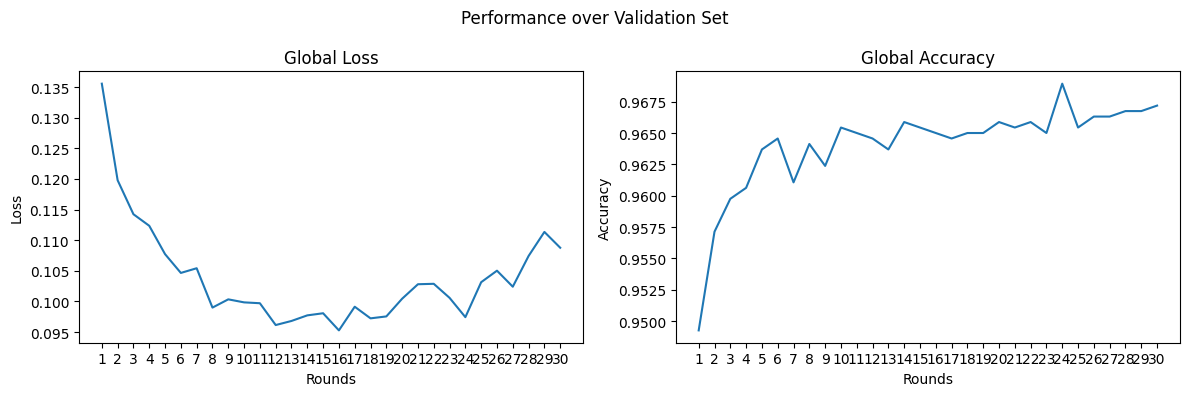

In [79]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(12, 4))
plt.suptitle("Performance over Validation Set")

# Plot for Global Loss
plt.subplot(121)
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.plot(range(1, len(global_loss_list_BiGRU) + 1), global_loss_list_BiGRU)
plt.xticks(range(1, len(global_loss_list_BiGRU) + 1))
plt.title("Global Loss")

# Plot for Global Accuracy
plt.subplot(122)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.plot(range(1, len(global_acc_list_BiGRU) + 1), global_acc_list_BiGRU)
plt.xticks(range(1, len(global_acc_list_BiGRU) + 1))
plt.title("Global Accuracy")

plt.tight_layout()
plt.show()


In [80]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Generate predictions
predictions = global_model.predict(X_test)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32").flatten()  # Convert to 1D array

# Check the shape of y_test
print("y_test shape:", y_test.shape)

# If y_test is one-hot encoded, convert it to binary labels
if len(y_test.shape) == 2 and y_test.shape[1] == 2:  # Assuming two classes
    true_labels = tf.argmax(y_test, axis=1).numpy()  # Convert to 1D array
else:
    true_labels = y_test  # Already 1D array

# Print classification metrics
class_report = classification_report(true_labels, predicted_labels, digits=6, zero_division=0)
print(class_report)

72/72 [==============================] - 1s 3ms/step
y_test shape: (2286,)
              precision    recall  f1-score   support

           0   0.963979  0.971478  0.967714      1157
           1   0.970536  0.962799  0.966652      1129

    accuracy                       0.967192      2286
   macro avg   0.967258  0.967138  0.967183      2286
weighted avg   0.967217  0.967192  0.967190      2286



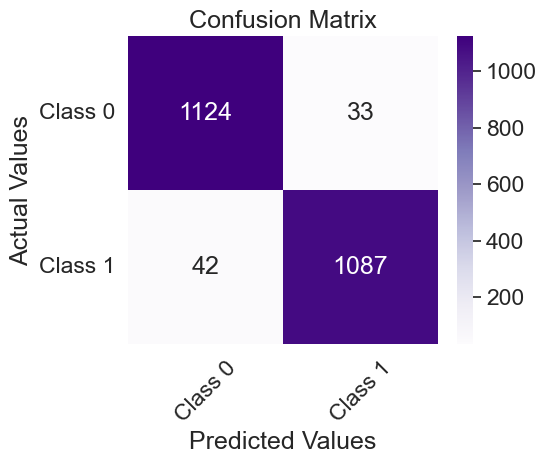

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming true_labels and predicted_labels are already defined

# Define class names for your binary classification
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, 
                 xticklabels=class_names, yticklabels=class_names)

# Labeling the axes
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Show the plot
plt.title('Confusion Matrix')
plt.show()

In [82]:
train_loss, train_acc = global_model.evaluate(X_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")


val_loss, val_acc = global_model.evaluate(X_test, y_test)
print(f"Global Validation Accuracy : {val_acc}")
print(f"Global Validation Loss : {val_loss}")
     

286/286 [==============================] - 1s 3ms/step - loss: 0.0729 - accuracy: 0.9756
Global Train Accuracy : 0.9756124019622803
Global Train Loss : 0.07292328774929047
72/72 [==============================] - 0s 3ms/step - loss: 0.1088 - accuracy: 0.9672
Global Validation Accuracy : 0.9671915769577026
Global Validation Loss : 0.10876831412315369


**GRU**

In [83]:
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

# Constants
BATCH_SIZE = 32
NUM_ROUNDS = 30
NUM_CLIENTS = 4  # Minimum must be 2

# Check the shape of X_train
print("X_train shape before reshaping:", X_train.shape)
if len(X_train.shape) == 2:  # (samples, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps=1, features)

# Check the shape of X_test
print("X_test shape before reshaping:", X_test.shape)
if len(X_test.shape) == 2:  # (samples, features)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # (samples, time_steps=1, features)

# Step 1: Define the Model Creation Function
def create_model():
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(GRU(64))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 2: Initialize Global Model
global_model = create_model()

global_acc_list_GRU = []
global_loss_list_GRU = []

# Start timing
cpu_start = time.process_time()
wall_start = time.time()

# Federated Learning Process
for epoch in range(NUM_ROUNDS):
    print(f'ROUND #{epoch + 1}/{NUM_ROUNDS}')

    # Client preparation
    client_models = []
    for i in range(NUM_CLIENTS):
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())
        client_models.append(client_model)

    # Training on local data
    for i in tqdm(range(NUM_CLIENTS)):
        print(f'____ Training CLIENT #{i + 1} ____')

        # Split data among clients
        start = i * (len(X_train) // NUM_CLIENTS)
        end = (i + 1) * (len(X_train) // NUM_CLIENTS)
        X_train_i = X_train[start:end]
        y_train_i = y_train[start:end]

        checkpoint = ModelCheckpoint(f"client_model_{i}.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=0)
        client_models[i].fit(X_train_i, y_train_i, batch_size=BATCH_SIZE, epochs=2, verbose=0, validation_split=0.2, callbacks=[checkpoint])

    # Federated Averaging
    average_weights = []
    for j in tqdm(range(len(global_model.get_weights()))):
        layer_weights = np.array([client_models[i].get_weights()[j] for i in range(NUM_CLIENTS)])
        average_layer_weights = np.mean(layer_weights, axis=0)
        average_weights.append(average_layer_weights)

    # Update Global Model
    global_model.set_weights(average_weights)

    # Evaluate the global model
    loss, acc = global_model.evaluate(X_train, y_train, verbose=0)
    print(f'Global Train Loss: {loss:.4f}, Global Train Accuracy: {acc:.4f}')

    # Evaluate on test set
    loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
    global_acc_list_GRU.append(acc)
    global_loss_list_GRU.append(loss)
    print(f'Global Validation Loss: {loss:.4f}, Global Validation Accuracy: {acc:.4f}')
    print('_________________________________________________________')

# Stop timing
cpu_end = time.process_time()
wall_end = time.time()

# Print CPU & Wall Time
print(f"Total CPU Time: {cpu_end - cpu_start:.2f} seconds")
print(f"Total Wall Time: {wall_end - wall_start:.2f} seconds")

# Print Global Accuracy and Loss Lists
print("\nGlobal Accuracy List (GRU):", global_acc_list_GRU)
print("Global Loss List (GRU):", global_loss_list_GRU)


X_train shape before reshaping: (9144, 1, 88)
X_test shape before reshaping: (2286, 1, 88)
ROUND #1/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.90s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.97s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.46s/it]

____ Training CLIENT #4 ____




00%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 90.56it/s]

Global Train Loss: 0.1696, Global Train Accuracy: 0.9373
Global Validation Loss: 0.1581, Global Validation Accuracy: 0.9436
_________________________________________________________
ROUND #2/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.08s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.35s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.08s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 120.12it/s]

Global Train Loss: 0.1454, Global Train Accuracy: 0.9458
Global Validation Loss: 0.1285, Global Validation Accuracy: 0.9549
_________________________________________________________
ROUND #3/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:14,  4.77s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:09<00:08,  4.47s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.16s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 139.24it/s]

Global Train Loss: 0.1372, Global Train Accuracy: 0.9485
Global Validation Loss: 0.1216, Global Validation Accuracy: 0.9549
_________________________________________________________
ROUND #4/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.07s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.12s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.29s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 126.07it/s]

Global Train Loss: 0.1312, Global Train Accuracy: 0.9521
Global Validation Loss: 0.1163, Global Validation Accuracy: 0.9580
_________________________________________________________
ROUND #5/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.81s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.11s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.89s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 121.47it/s]

Global Train Loss: 0.1259, Global Train Accuracy: 0.9526
Global Validation Loss: 0.1122, Global Validation Accuracy: 0.9593
_________________________________________________________
ROUND #6/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:13,  4.38s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.09s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.89s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 111.07it/s]

Global Train Loss: 0.1216, Global Train Accuracy: 0.9547
Global Validation Loss: 0.1093, Global Validation Accuracy: 0.9606
_________________________________________________________
ROUND #7/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.01s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.02s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.88s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 129.56it/s]

Global Train Loss: 0.1181, Global Train Accuracy: 0.9565
Global Validation Loss: 0.1082, Global Validation Accuracy: 0.9589
_________________________________________________________
ROUND #8/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.88s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.83s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.08s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 123.94it/s]

Global Train Loss: 0.1143, Global Train Accuracy: 0.9578
Global Validation Loss: 0.1057, Global Validation Accuracy: 0.9633
_________________________________________________________
ROUND #9/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.71s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.24s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.10s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 140.13it/s]

Global Train Loss: 0.1110, Global Train Accuracy: 0.9595
Global Validation Loss: 0.1033, Global Validation Accuracy: 0.9637
_________________________________________________________
ROUND #10/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.70s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.23s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.08s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 126.55it/s]

Global Train Loss: 0.1073, Global Train Accuracy: 0.9608
Global Validation Loss: 0.1023, Global Validation Accuracy: 0.9646
_________________________________________________________
ROUND #11/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.96s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.90s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.90s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 140.64it/s]

Global Train Loss: 0.1049, Global Train Accuracy: 0.9624
Global Validation Loss: 0.1017, Global Validation Accuracy: 0.9650
_________________________________________________________
ROUND #12/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.81s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.90s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.18s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 156.17it/s]

Global Train Loss: 0.1022, Global Train Accuracy: 0.9634
Global Validation Loss: 0.1004, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #13/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.78s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.14s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.99s/it]

____ Training CLIENT #4 ____




00%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 97.56it/s]

Global Train Loss: 0.1000, Global Train Accuracy: 0.9648
Global Validation Loss: 0.0998, Global Validation Accuracy: 0.9659
_________________________________________________________
ROUND #14/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:14,  4.69s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.23s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.01s/it]

____ Training CLIENT #4 ____




00%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 99.07it/s]

Global Train Loss: 0.0979, Global Train Accuracy: 0.9649
Global Validation Loss: 0.1013, Global Validation Accuracy: 0.9659
_________________________________________________________
ROUND #15/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:10,  3.58s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.59s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.99s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 122.94it/s]

Global Train Loss: 0.0959, Global Train Accuracy: 0.9662
Global Validation Loss: 0.0994, Global Validation Accuracy: 0.9676
_________________________________________________________
ROUND #16/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.01s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.02s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.24s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 109.36it/s]

Global Train Loss: 0.0936, Global Train Accuracy: 0.9671
Global Validation Loss: 0.0960, Global Validation Accuracy: 0.9676
_________________________________________________________
ROUND #17/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.73s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.14s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.13s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 120.55it/s]

Global Train Loss: 0.0920, Global Train Accuracy: 0.9684
Global Validation Loss: 0.0987, Global Validation Accuracy: 0.9672
_________________________________________________________
ROUND #18/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:13,  4.38s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.05s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.93s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 142.01it/s]

Global Train Loss: 0.0906, Global Train Accuracy: 0.9698
Global Validation Loss: 0.0983, Global Validation Accuracy: 0.9676
_________________________________________________________
ROUND #19/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.03s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.86s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.27s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 119.99it/s]

Global Train Loss: 0.0892, Global Train Accuracy: 0.9700
Global Validation Loss: 0.0961, Global Validation Accuracy: 0.9689
_________________________________________________________
ROUND #20/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.67s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:08,  4.04s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.98s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 126.25it/s]

Global Train Loss: 0.0875, Global Train Accuracy: 0.9703
Global Validation Loss: 0.0965, Global Validation Accuracy: 0.9685
_________________________________________________________
ROUND #21/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:13,  4.55s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.21s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:03,  3.98s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 127.73it/s]

Global Train Loss: 0.0857, Global Train Accuracy: 0.9707
Global Validation Loss: 0.0961, Global Validation Accuracy: 0.9672
_________________________________________________________
ROUND #22/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.68s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.70s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.81s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 129.98it/s]

Global Train Loss: 0.0852, Global Train Accuracy: 0.9724
Global Validation Loss: 0.0968, Global Validation Accuracy: 0.9676
_________________________________________________________
ROUND #23/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.87s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.99s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.94s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 131.86it/s]

Global Train Loss: 0.0836, Global Train Accuracy: 0.9731
Global Validation Loss: 0.0994, Global Validation Accuracy: 0.9668
_________________________________________________________
ROUND #24/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.78s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.72s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.18s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 109.07it/s]

Global Train Loss: 0.0820, Global Train Accuracy: 0.9732
Global Validation Loss: 0.0997, Global Validation Accuracy: 0.9668
_________________________________________________________
ROUND #25/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.90s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.13s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.97s/it]

____ Training CLIENT #4 ____




00%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 81.01it/s]

Global Train Loss: 0.0813, Global Train Accuracy: 0.9732
Global Validation Loss: 0.1002, Global Validation Accuracy: 0.9668
_________________________________________________________
ROUND #26/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:13,  4.39s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.08s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.92s/it]

____ Training CLIENT #4 ____




00%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 75.33it/s]

Global Train Loss: 0.0800, Global Train Accuracy: 0.9733
Global Validation Loss: 0.1004, Global Validation Accuracy: 0.9663
_________________________________________________________
ROUND #27/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.97s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.78s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.06s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 143.55it/s]

Global Train Loss: 0.0795, Global Train Accuracy: 0.9740
Global Validation Loss: 0.1005, Global Validation Accuracy: 0.9672
_________________________________________________________
ROUND #28/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.67s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.69s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.97s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 116.24it/s]

Global Train Loss: 0.0788, Global Train Accuracy: 0.9748
Global Validation Loss: 0.0994, Global Validation Accuracy: 0.9676
_________________________________________________________
ROUND #29/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:04<00:14,  4.81s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:09<00:09,  4.52s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.13s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 125.51it/s]

Global Train Loss: 0.0780, Global Train Accuracy: 0.9743
Global Validation Loss: 0.1015, Global Validation Accuracy: 0.9659
_________________________________________________________
ROUND #30/30


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

____ Training CLIENT #1 ____


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.85s/it]

____ Training CLIENT #2 ____


 50%|██████████████████████████████████████████                                          | 2/4 [00:07<00:07,  3.97s/it]

____ Training CLIENT #3 ____


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:11<00:03,  3.96s/it]

____ Training CLIENT #4 ____




00%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 133.55it/s]

Global Train Loss: 0.0775, Global Train Accuracy: 0.9740
Global Validation Loss: 0.1010, Global Validation Accuracy: 0.9659
_________________________________________________________
Total CPU Time: 162.58 seconds
Total Wall Time: 557.83 seconds

Global Accuracy List (GRU): [0.943569540977478, 0.9549431204795837, 0.9549431204795837, 0.9580052495002747, 0.9593175649642944, 0.960629940032959, 0.9588801264762878, 0.9632545709609985, 0.9636920094490051, 0.9645669460296631, 0.9650043845176697, 0.9663166999816895, 0.9658792614936829, 0.9658792614936829, 0.967629075050354, 0.967629075050354, 0.9671915769577026, 0.967629075050354, 0.9689413905143738, 0.9685039520263672, 0.9671915769577026, 0.967629075050354, 0.966754138469696, 0.966754138469696, 0.966754138469696, 0.9663166999816895, 0.9671915769577026, 0.967629075050354, 0.9658792614936829, 0.9658792614936829]
Global Loss List (GRU): [0.15808755159378052, 0.12849414348602295, 0.12164551019668579, 0.11625174432992935, 0.11222062259912491, 0.109

In [84]:
train_loss, train_acc = global_model.evaluate(X_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")


val_loss, val_acc = global_model.evaluate(X_test, y_test)
print(f"Global Validation Accuracy : {val_acc}")
print(f"Global Validation Loss : {val_loss}")

286/286 [==============================] - 1s 3ms/step - loss: 0.0775 - accuracy: 0.9740
Global Train Accuracy : 0.9739720225334167
Global Train Loss : 0.07752001285552979
72/72 [==============================] - 0s 3ms/step - loss: 0.1010 - accuracy: 0.9659
Global Validation Accuracy : 0.9658792614936829
Global Validation Loss : 0.10095953941345215


In [85]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Generate predictions
predictions = global_model.predict(X_test)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32").flatten()  # Convert to 1D array

# Check the shape of y_test
print("y_test shape:", y_test.shape)

# If y_test is one-hot encoded, convert it to binary labels
if len(y_test.shape) == 2 and y_test.shape[1] == 2:  # Assuming two classes
    true_labels = tf.argmax(y_test, axis=1).numpy()  # Convert to 1D array
else:
    true_labels = y_test  # Already 1D array

# Print classification metrics
class_report = classification_report(true_labels, predicted_labels, digits=6, zero_division=0)
print(class_report)

72/72 [==============================] - 1s 2ms/step
y_test shape: (2286,)
              precision    recall  f1-score   support

           0   0.961506  0.971478  0.966466      1157
           1   0.970457  0.960142  0.965272      1129

    accuracy                       0.965879      2286
   macro avg   0.965981  0.965810  0.965869      2286
weighted avg   0.965926  0.965879  0.965876      2286



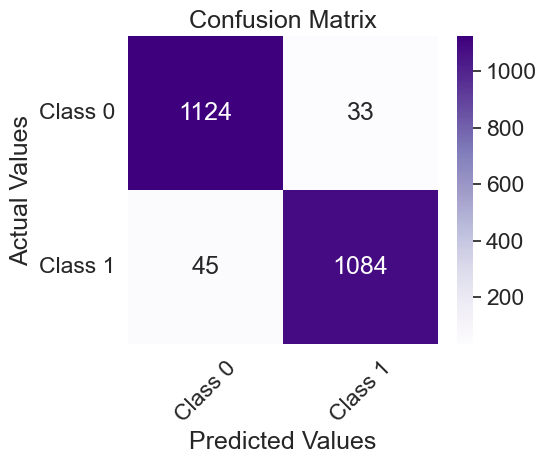

In [86]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming true_labels and predicted_labels are already defined

# Define class names for your binary classification
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, 
                 xticklabels=class_names, yticklabels=class_names)

# Labeling the axes
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Show the plot
plt.title('Confusion Matrix')
plt.show()

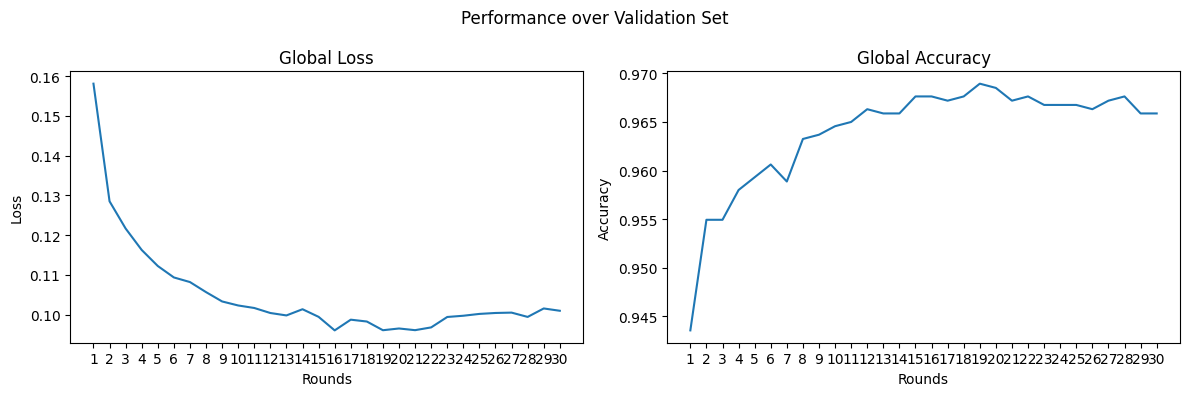

In [87]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(12, 4))
plt.suptitle("Performance over Validation Set")

# Plot for Global Loss
plt.subplot(121)
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.plot(range(1, len(global_loss_list_GRU) + 1), global_loss_list_GRU)
plt.xticks(range(1, len(global_loss_list_GRU) + 1))
plt.title("Global Loss")

# Plot for Global Accuracy
plt.subplot(122)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.plot(range(1, len(global_acc_list_GRU) + 1), global_acc_list_GRU)
plt.xticks(range(1, len(global_acc_list_GRU) + 1))
plt.title("Global Accuracy")

plt.tight_layout()
plt.show()


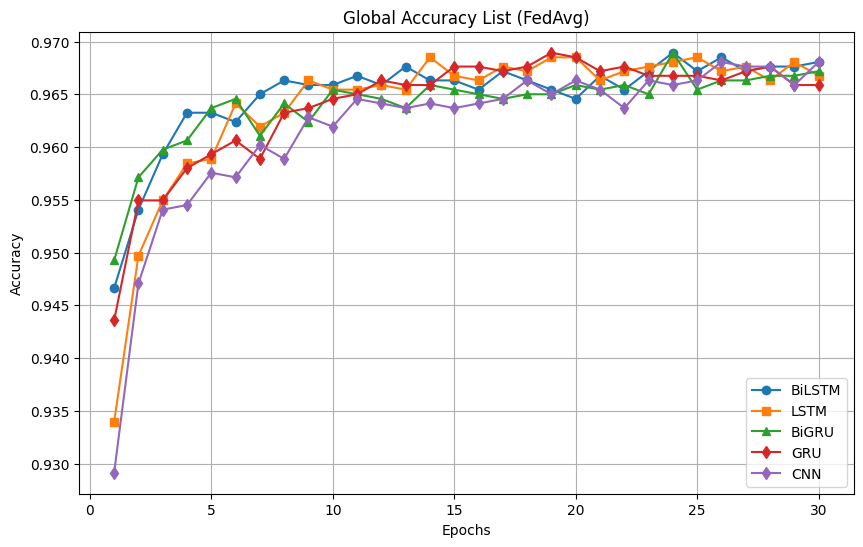

In [91]:
import matplotlib.pyplot as plt

# Define epochs
epochs = list(range(1, 31))  # 1 to 30

# Plot accuracy for each model
plt.figure(figsize=(10, 6))

plt.plot(epochs, global_acc_list_BiLSTM, label="BiLSTM", marker='o')
plt.plot(epochs, global_acc_list_LSTM, label="LSTM", marker='s')
plt.plot(epochs, global_acc_list_BiGRU, label="BiGRU", marker='^')
plt.plot(epochs, global_acc_list_GRU, label="GRU", marker='d')
plt.plot(epochs, global_acc_list_CNN, label="CNN", marker='d')

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Global Accuracy List (FedAvg)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

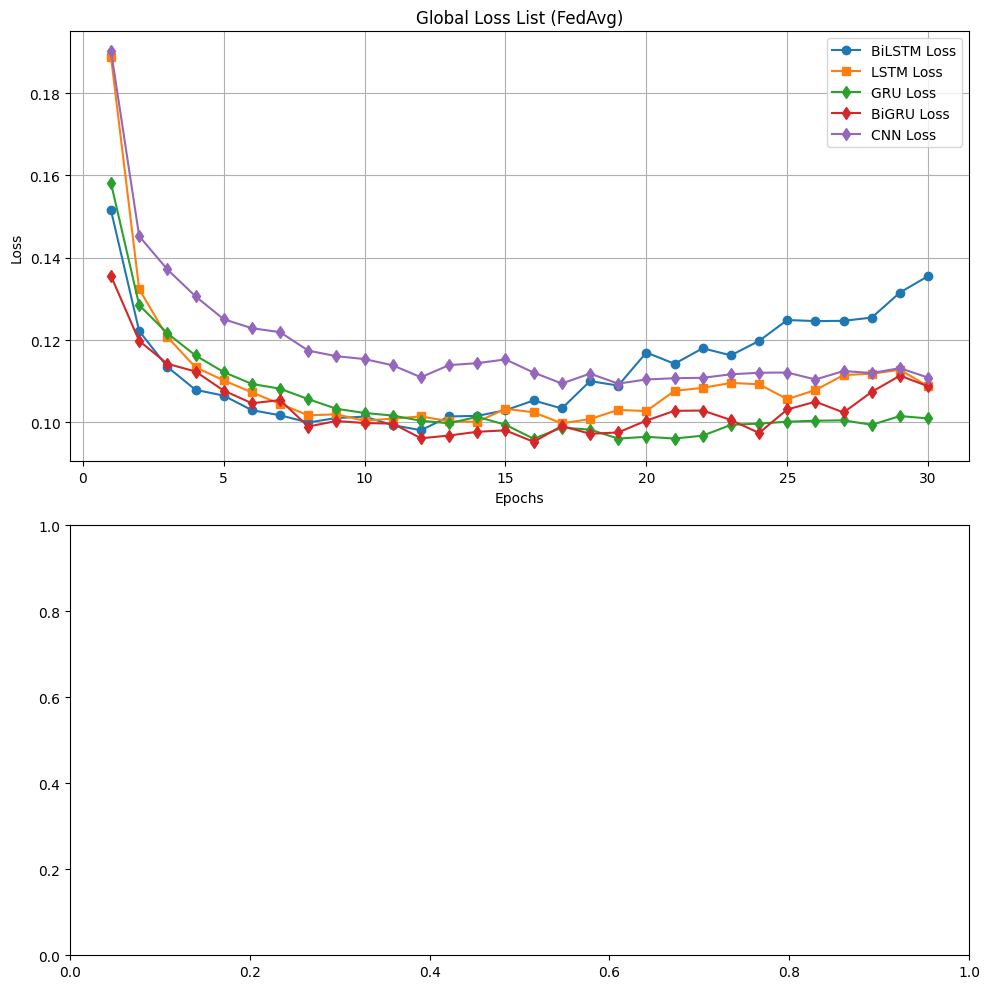

In [90]:
import matplotlib.pyplot as plt

# Define epochs
epochs = list(range(1, 31))  # 1 to 30

# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# 📉 Plot Loss for BiLSTM, LSTM, GRU
ax[0].plot(epochs, global_loss_list_BiLSTM, label="BiLSTM Loss", marker='o')
ax[0].plot(epochs, global_loss_list_LSTM, label="LSTM Loss", marker='s')
ax[0].plot(epochs, global_loss_list_GRU, label="GRU Loss", marker='d')
ax[0].plot(epochs, global_loss_list_BiGRU, label="BiGRU Loss", marker='d')
ax[0].plot(epochs, global_loss_list_CNN, label="CNN Loss", marker='d')

ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Global Loss List (FedAvg)")
ax[0].legend()
ax[0].grid(True)


# Adjust layout and show plot
plt.tight_layout()
plt.show()
